<a href="https://colab.research.google.com/github/Syilun/TibameAI04/blob/master/Activation_Function_AllStar_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
print(matplotlib.get_backend())
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 8})

module://ipykernel.pylab.backend_inline


## 活化函數大清點 (pytorch)

支援python 版本: 3.5以上
支援pytorch版本 : 1.2以上

In [ ]:
import gc
import glob
import os
import cv2
import time
#!pip uninstall tridentx
!pip install '/content/gdrive/My Drive/DeepBelief_Course5_Examples/tridentx-0.5.0-py3-none-any.whl'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.layers.pytorch_activations import __all__

trident 0.5.0
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:7.0.0.
Pytorch version:1.4.0.


這個實作是關於活化函數的理解。在神經元的底層結構中，活化函數扮演著將收到的信號賦予非線性特性的關鍵角色，也因此活化函數雖然不是太顯眼，但是仍有不少研究者推出新的活化函數希望可以藉由活化函數來提升模型效度。

在我這次為課程封裝的 API trident 中，只需要利用get_activation('活化函數名稱')即可回傳對應的活化函數，我們可以利用它結合Matplotlib 來繪製值域以及一階導數分布圖。

<IPython.core.display.Javascript object>

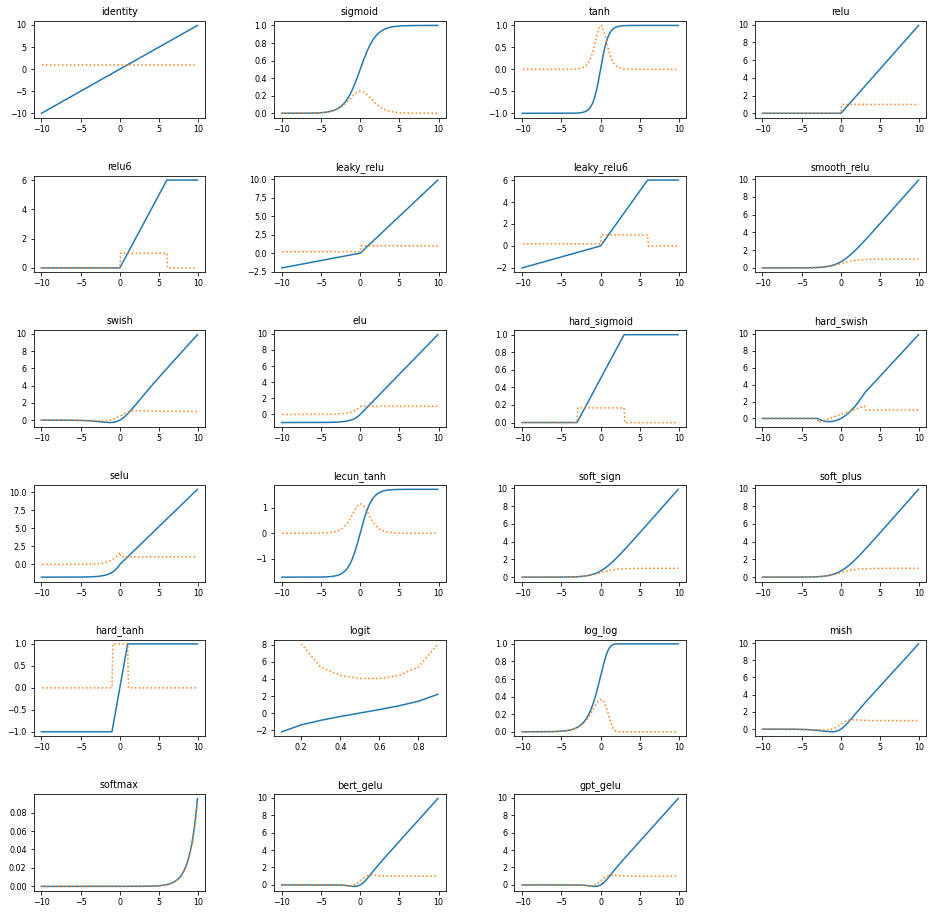

In [ ]:
fig=plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
n=1
items= __all__[int( len(__all__)//2):-1]
plt.clf()
for k in  items :
    if k not in ('p_relu','prelu'):
        try:
            act_fn=get_activation(k)
            x =np.arange(-10, 10, 0.1).astype(np.float32)
            tensor_x=to_tensor(x)
            y=to_numpy(act_fn(tensor_x))
            ax1 = fig.add_subplot(6, 4, n)
            ax1.plot(x,y)
            ax1.plot(x[1:], np.diff(y) /(np.diff(x)+1e-8),ls=':')
            ax1.set_title(k)
            
        except Exception as e:
            print(e)
            pass
        n+=1
display.display(fig)

接下來我們想要評測一下幾個傳統活化函數與新的活化函數之間的效能差異，我們將從幾點來評估它:
1.  計算時長(表示計算的開銷)
2. 跑 mnist 1000 minibatch 的訓練階段最佳accuracy以及最後10個批次的accuracy
3. 使用一樣的數據進行推論
4. 使用加入大量噪聲的數據進行推論(確認跑出來模型的通用性)
5. 檢視訓練過程的梯度與權重分布
6. 梯度為零比率

下面的語法是使用trident API 讀取mnist數據集
你也可以換成T.load_mnist(' fashion-mnist','train',is_flatten=True)來改讀取fashion mnist

In [ ]:
dataset=T.load_mnist('mnist')
dataset.image_transform_funcs=[normalize(127.5,127.5)]       


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.


若是要產生加入高度噪聲的數據，只需要在noise_dataset.image_transform_funcs中多加入個add_noise(intensity=0.3)，表示會加入30% 強度的隨機噪音，我們將它產生的數據輸出看一下，會是如下圖的結果，使用他的目的在於用乾淨的數據訓練，看看它第一次遇到那麼髒的數據的效度會有多大的程度衰退。

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
(64, 28, 28)


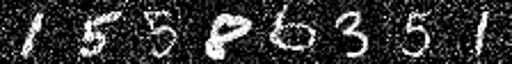

In [ ]:
noise_dataset=T.load_mnist('mnist')
noise_dataset.image_transform_funcs=[normalize(127.5,127.5),add_noise(intensity=0.3)]       
noise_dataset.minibatch_size=64

im,label=noise_dataset.next()
print(im.shape)
im=array2image(np.concatenate(np.reshape(im[:8,:]*127.5+127.5,(8,28,28)).tolist(),1)).resize((64*8,64))
im

接下來就把要測試的目標包裝成測試函數

In [ ]:
activations=['relu','sigmoid','tanh','selu','swish','mish']
performance_dict=OrderedDict()
def test_activity_function(act):
    performance_dict[act]=OrderedDict()
    #清掉記憶體垃圾以避免影響效能
    gc.collect()
    act_func=get_activation(act)
    print(act)
    
    #計算跑 10 萬次的總時間
    data =to_tensor(np.random.standard_normal((100000,1))) 
    start = time.time()
    results=[act_func(data[i]) for  i  in range(100000)]
    sec = time.time() - start
    print('{0:.6f} sec'.format(sec))
    performance_dict[act]['跑 10 萬次的總時間']=sec

    #建 mnist模
    net=Sequential(
    Flatten(),
    Dense(64,use_bias=False,activation=act),
    Dense(10,use_bias=False,activation='softmax'))
   

    #為了避免 Adam自適應調整對測試的影響，這裡使用SGD 
    model=Model(input_shape=(28,28),output=net)\
    .with_optimizer(optimizer='SGD',lr=1e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)
    
    plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(dataset)\
    .within_minibatch_size(128)\
    .print_progress_scheduling(100,unit='batch')\

    #讓他跑1000 次，過程中的權重變化與梯度變化都保留
    plan.only_steps(num_steps=1000,keep_weights_history=True,keep_gradient_history=True )
   
    #計算效度指標
    print('最低 loss {0:.4e}  最佳 metrics {1:.4%}  最後10次 metrics {2:.4%}'.format(min(plan.training_items[0].batch_loss_history['total_losses']),\
                                                                              max(plan.training_items[0].batch_metric_history['accuracy']) ,\
                                                                              np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))
    performance_dict[act]['最佳 metrics']= max(plan.training_items[0].batch_metric_history['accuracy'])
    performance_dict[act]['最後10次 metrics']= np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()
    # 分別使用乾淨數據與噪聲數據進行推論
    net.eval()
    accuracys=[]
    for i in range(100):
        input,target=dataset.next()
        input,target=to_tensor(input),to_tensor(target)
        accuracys.append(to_numpy(accuracy(net(input),target)))
    accuracys=np.asarray(accuracys)
        
    print('正常樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(accuracys.mean(),accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))
    performance_dict[act]['正常樣本 accuracy DIFF']=accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()
    
    
    noise_accuracys=[]
    for i in range(100):
        input,target=noise_dataset.next()
        input,target=to_tensor(input),to_tensor(target)
        noise_accuracys.append(to_numpy(accuracy(net(input),target)))
    noise_accuracys=np.asarray(noise_accuracys)
        
    print('噪聲樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(noise_accuracys.mean(),noise_accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))
    performance_dict[act]['噪聲樣本 accuracy DIFF']=noise_accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()
    
    #繪製梯度與權重分布
    weights_history=plan.training_items[0].weights_history
    gradients_history=plan.training_items[0].gradients_history
   
    grads=[]
    weights=[]
    for i in range(len(gradients_history)):
        grads.append(gradients_history[i].value_list[0].reshape([-1]))

    for i in range(len(weights_history)):
         weights.append(weights_history[i].value_list[0].reshape([-1]))
 
    grads=np.asarray(grads)
    weights=np.asarray(weights)
    #計算梯度為零比例
    print('梯度為零比例 : {0:.3%}'.format(np.equal(grads,0).astype(np.float32).mean()))
    performance_dict[act]['梯度為零比例']=np.equal(grads,0).astype(np.float32).mean()
    performance_dict[act]['負梯度比例']=np.less(grads,0).astype(np.float32).mean()
    
    steps_histogram(grads,weights,inteval=50,imshow=True)
    
    
    fig = plt.figure(figsize=(18,8))
    for i in [1,2]:
        ax= fig.add_subplot(1, 2, i, projection = '3d')


        # Make data.
        X = np.arange(0, 28, 1)
        Y = np.arange(0, 28, 1)
        X, Y = np.meshgrid(X, Y)
        grad_grid=gradients_history[0 if i==1 else-1].value_list[0][0,:].reshape([28,28])
        Z = grad_grid[Y,X]

        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(grad_grid.min()*1.1,grad_grid.max()*1.1)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        fig.colorbar(surf, shrink=0.5, aspect=5)

    display.display(plt.gcf())
   
    

relu
1.325241 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 7s530ms  | Loss: 2.297   | accuracy: 17.969%  | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.297084093093872), ('CrossEntropyLoss', 2.297084093093872)])
model 0      Step: 723ms    | Loss: 2.301   | accuracy: 14.477%  | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 749ms    | Loss: 2.300   | accuracy: 15.031%  | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 747ms    | Loss: 2.299   | accuracy: 15.711%  | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 718ms    | Loss: 2.298   | accuracy: 16.055%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 718ms    | Loss: 2.297   | accuracy: 16.359%  | learning rate: 1.000e-03 

<IPython.core.display.Javascript object>

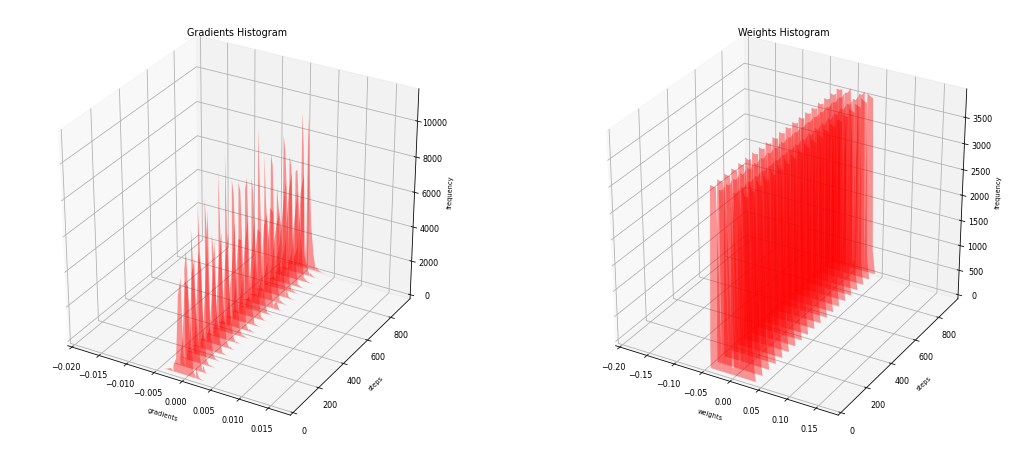

<IPython.core.display.Javascript object>

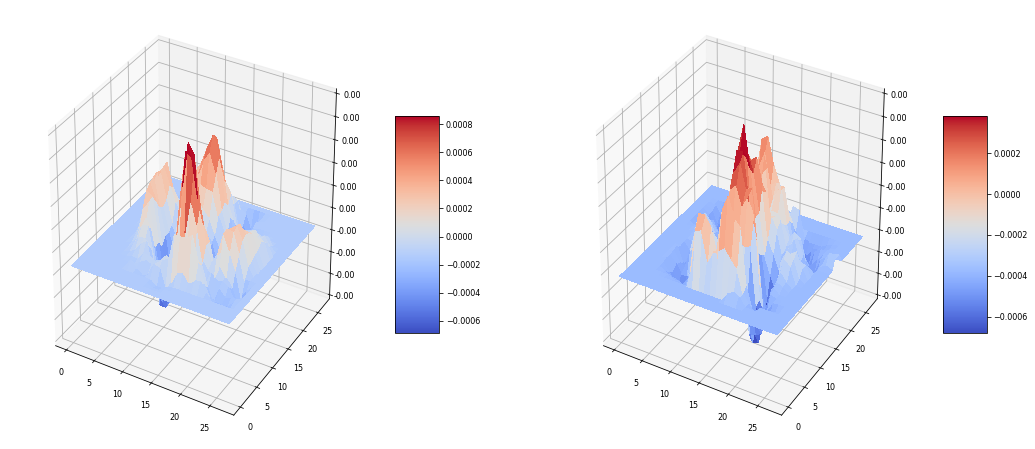

In [ ]:
test_activity_function('relu')

leaky_relu
1.311420 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 5s276ms  | Loss: 2.308   | accuracy: 8.594%   | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.307589292526245), ('CrossEntropyLoss', 2.307589292526245)])
model 0      Step: 728ms    | Loss: 2.304   | accuracy: 12.727%  | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 724ms    | Loss: 2.303   | accuracy: 13.156%  | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 711ms    | Loss: 2.302   | accuracy: 13.562%  | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 730ms    | Loss: 2.301   | accuracy: 15.000%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 720ms    | Loss: 2.300   | accuracy: 14.875%  | learning rate: 1.00

<IPython.core.display.Javascript object>

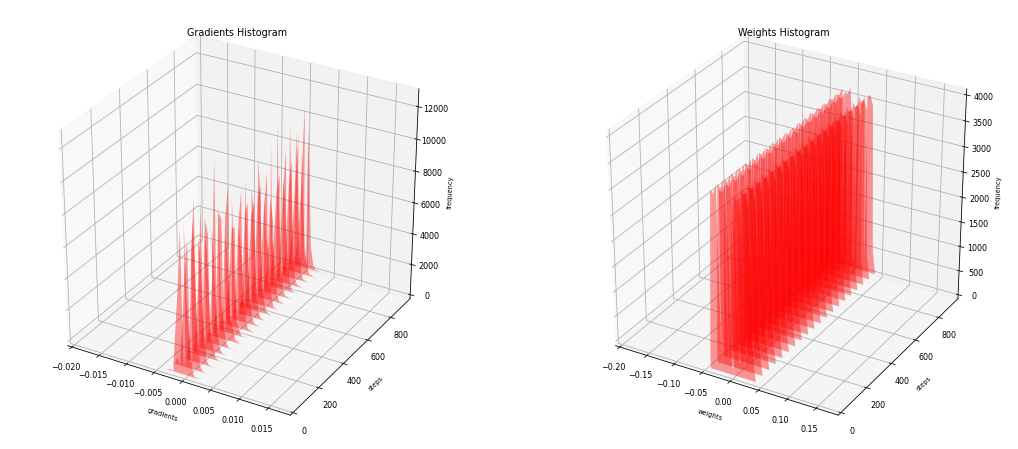

<IPython.core.display.Javascript object>

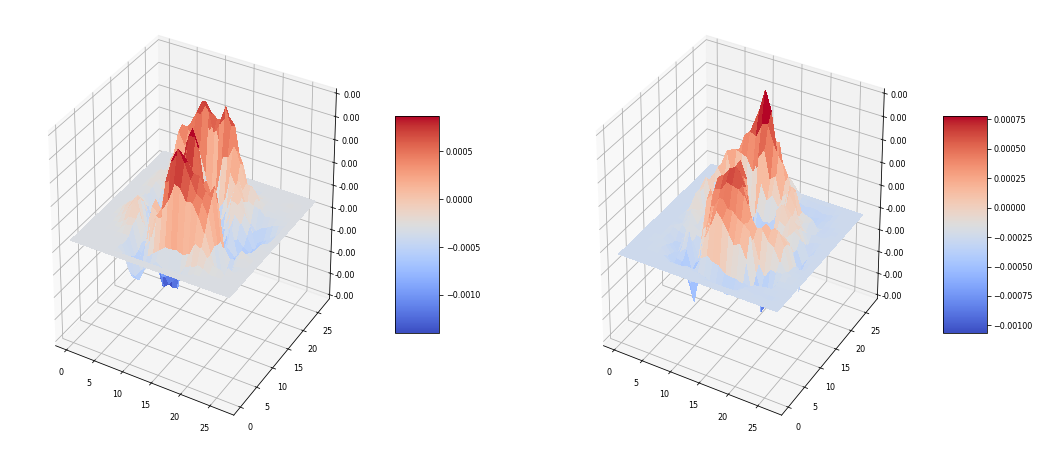

In [ ]:
test_activity_function('leaky_relu')

sigmoid
1.373938 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 5s228ms  | Loss: 2.299   | accuracy: 13.281%  | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.299315929412842), ('CrossEntropyLoss', 2.299315929412842)])
model 0      Step: 700ms    | Loss: 2.302   | accuracy: 10.477%  | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 706ms    | Loss: 2.303   | accuracy: 9.891%   | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 710ms    | Loss: 2.303   | accuracy: 9.812%   | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 716ms    | Loss: 2.303   | accuracy: 10.406%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 707ms    | Loss: 2.302   | accuracy: 10.742%  | learning rate: 1.000e-

<IPython.core.display.Javascript object>

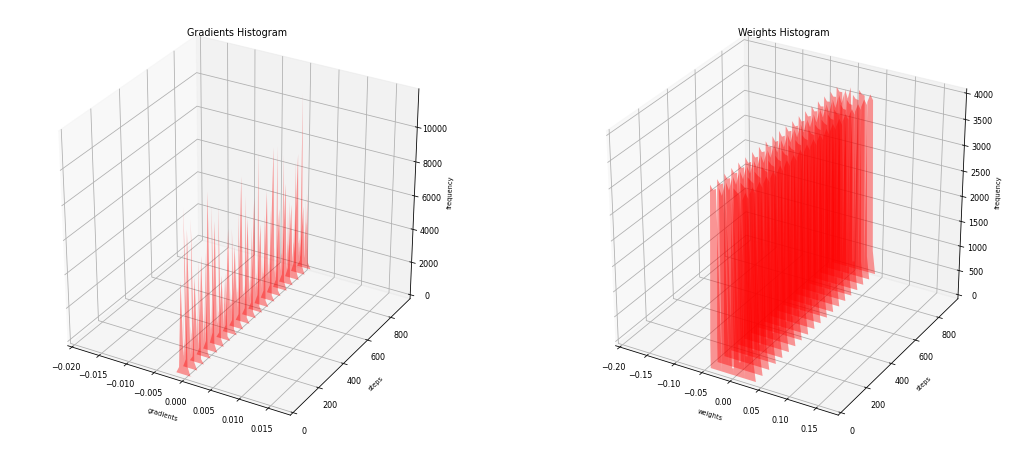

<IPython.core.display.Javascript object>

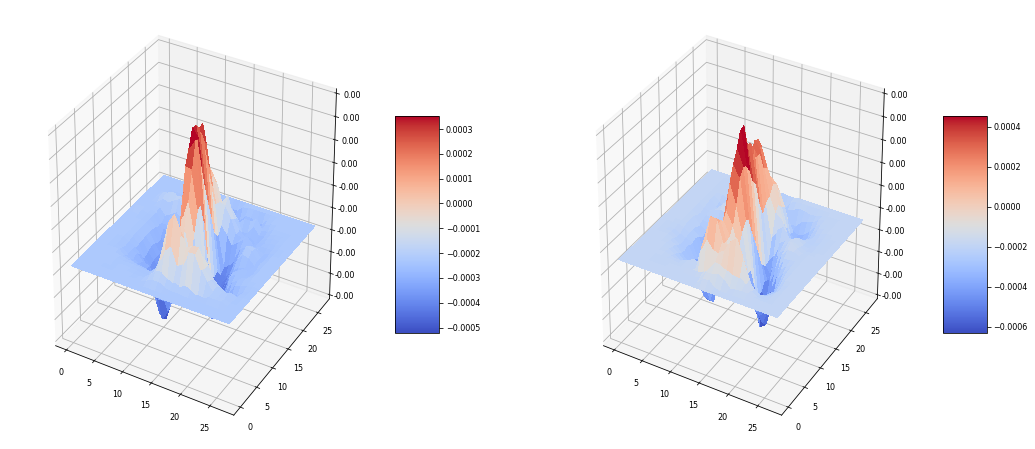

In [ ]:
test_activity_function('sigmoid')

tanh
1.357773 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 5s251ms  | Loss: 2.307   | accuracy: 8.594%   | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.3066036701202393), ('CrossEntropyLoss', 2.3066036701202393)])
model 0      Step: 710ms    | Loss: 2.306   | accuracy: 8.398%   | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 738ms    | Loss: 2.305   | accuracy: 10.250%  | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 739ms    | Loss: 2.304   | accuracy: 11.953%  | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 711ms    | Loss: 2.303   | accuracy: 13.289%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 707ms    | Loss: 2.301   | accuracy: 15.047%  | learning rate: 1.000e-0

<IPython.core.display.Javascript object>

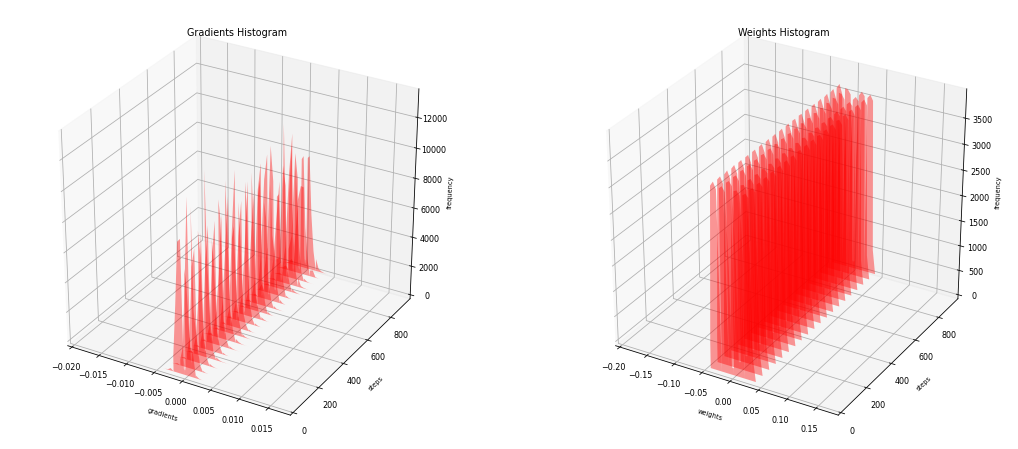

<IPython.core.display.Javascript object>

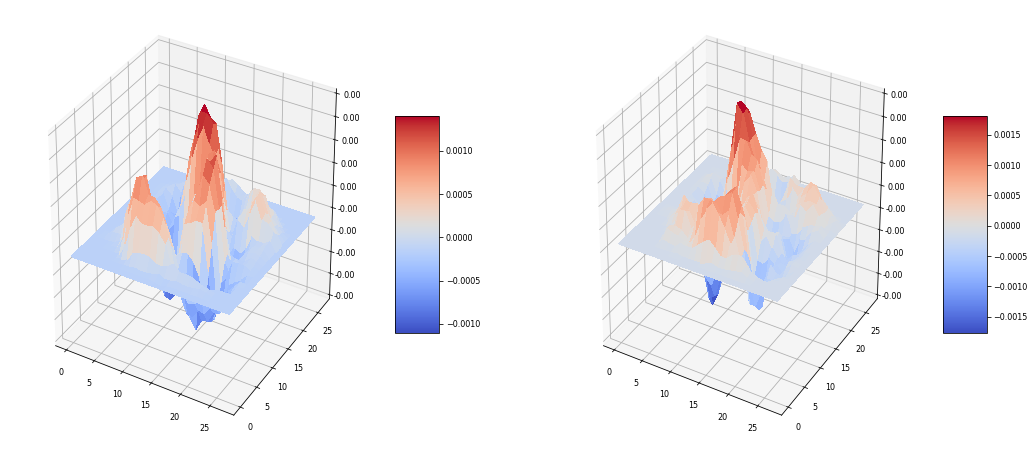

In [ ]:
test_activity_function('tanh')

selu
1.248160 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 5s125ms  | Loss: 2.304   | accuracy: 11.719%  | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.303891658782959), ('CrossEntropyLoss', 2.303891658782959)])
model 0      Step: 725ms    | Loss: 2.303   | accuracy: 10.211%  | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 700ms    | Loss: 2.300   | accuracy: 11.867%  | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 709ms    | Loss: 2.298   | accuracy: 12.672%  | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 701ms    | Loss: 2.294   | accuracy: 14.055%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 697ms    | Loss: 2.292   | accuracy: 14.859%  | learning rate: 1.000e-03 

<IPython.core.display.Javascript object>

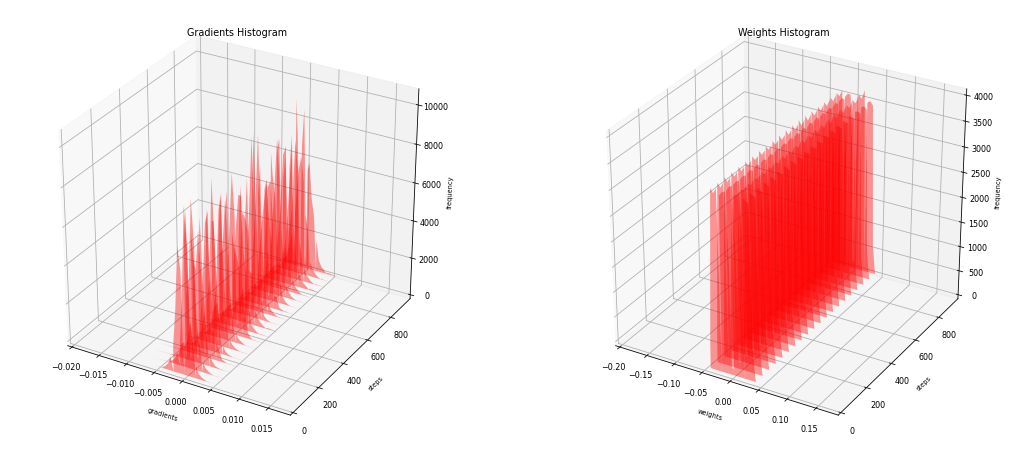

<IPython.core.display.Javascript object>

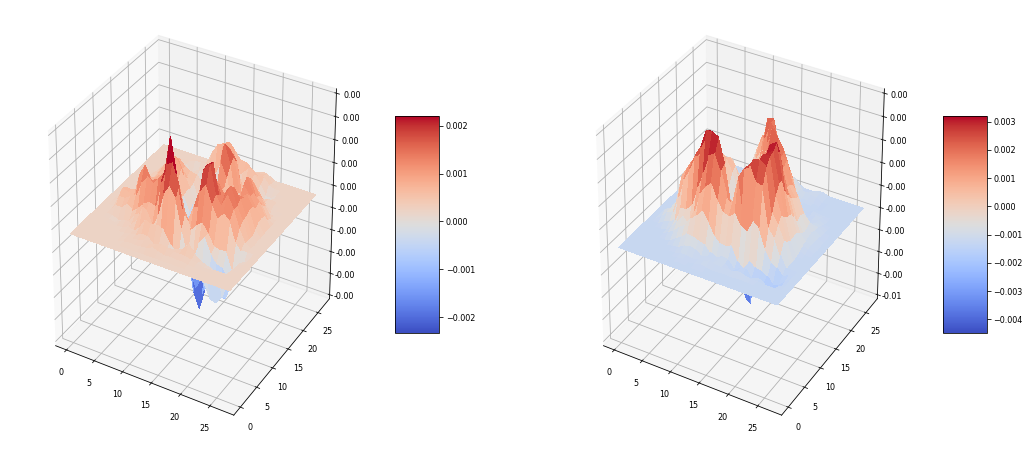

In [ ]:
test_activity_function('selu')

swish
2.383610 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 6s283ms  | Loss: 2.304   | accuracy: 12.500%  | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.303598403930664), ('CrossEntropyLoss', 2.303598403930664)])
model 0      Step: 712ms    | Loss: 2.304   | accuracy: 9.750%   | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 729ms    | Loss: 2.303   | accuracy: 10.648%  | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 715ms    | Loss: 2.302   | accuracy: 10.383%  | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 720ms    | Loss: 2.302   | accuracy: 10.688%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 723ms    | Loss: 2.301   | accuracy: 10.508%  | learning rate: 1.000e-03

<IPython.core.display.Javascript object>

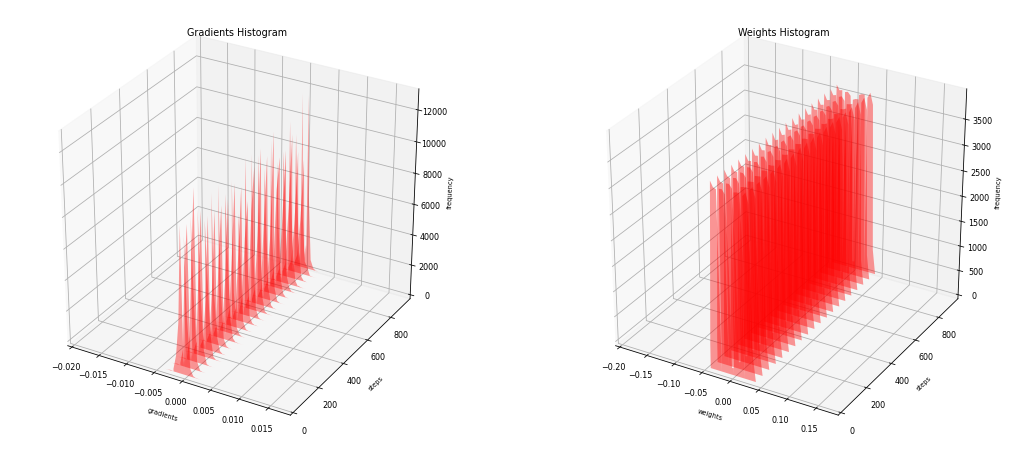

<IPython.core.display.Javascript object>

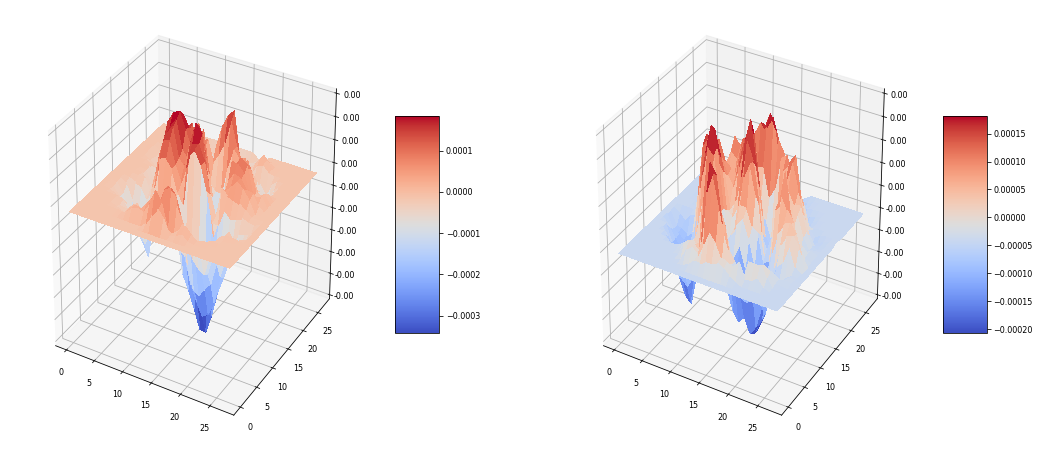

In [ ]:
test_activity_function('swish')

mish
3.345758 sec
CrossEntropyLoss signature:[('output', [10]), ('target', [10])]
accuracy signature:[('output', [10]), ('target', [10])]
data_feed for model 0 :OrderedDict([('x', 'data'), ('output', 'output'), ('target', 'label')])
model 0      Step: 7s192ms  | Loss: 2.303   | accuracy: 10.938%  | learning rate: 1.000e-03 | epoch: 0  ( 0/1000 )
OrderedDict([('total_losses', 2.3030595779418945), ('CrossEntropyLoss', 2.3030595779418945)])
model 0      Step: 725ms    | Loss: 2.302   | accuracy: 10.617%  | learning rate: 1.000e-03 | epoch: 0  ( 100/1000 )
model 0      Step: 732ms    | Loss: 2.301   | accuracy: 11.148%  | learning rate: 1.000e-03 | epoch: 0  ( 200/1000 )
model 0      Step: 731ms    | Loss: 2.300   | accuracy: 12.617%  | learning rate: 1.000e-03 | epoch: 0  ( 300/1000 )
model 0      Step: 753ms    | Loss: 2.299   | accuracy: 13.445%  | learning rate: 1.000e-03 | epoch: 0  ( 400/1000 )
model 0      Step: 718ms    | Loss: 2.299   | accuracy: 13.398%  | learning rate: 1.000e-0

<IPython.core.display.Javascript object>

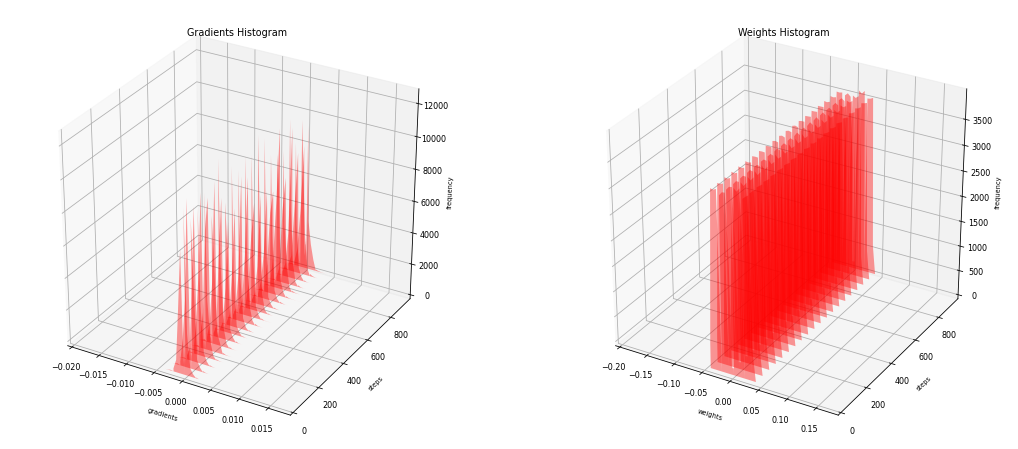

<IPython.core.display.Javascript object>

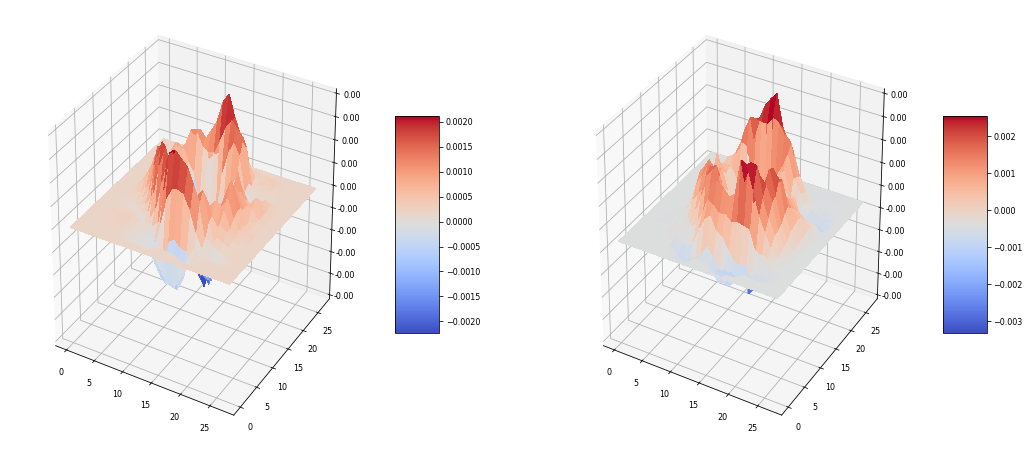

In [ ]:
test_activity_function('mish')

In [ ]:
import pandas
pd=pandas.DataFrame.from_dict(performance_dict)
pd

,relu,leaky_relu,sigmoid,tanh,selu,swish,mish
跑 10 萬次的總時間,1.325241,1.311420e+00,1.373938,1.357773,1.248160e+00,2.383610e+00,3.345758e+00
最佳 metrics,0.281250,2.578125e-01,0.187500,0.320312,3.203125e-01,2.421875e-01,3.046875e-01
最後10次 metrics,0.196094,1.828125e-01,0.111719,0.202344,1.835938e-01,1.703125e-01,2.281250e-01
正常樣本 accuracy DIFF,-0.011562,-1.328129e-03,-0.012109,0.020469,5.078122e-03,-2.500004e-03,-9.296873e-03
噪聲樣本 accuracy DIFF,-0.019844,-1.656249e-02,-0.008594,-0.013906,6.249994e-03,-9.374997e-03,-3.296875e-02
梯度為零比例,0.047203,1.992985e-08,0.000000,0.000000,3.985969e-08,1.992985e-08,1.992985e-08
負梯度比例,0.408006,4.999058e-01,0.499592,0.490301,4.979618e-01,4.895555e-01,4.991597e-01
